In [1]:
import torch
import pytorch3d
import matplotlib.pyplot as plt

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    PointsRasterizer,
    PointsRasterizationSettings,
)
from src.ShadingPointsRenderer import (    
    ShadingCompositor,
    ShadingPointsRenderer,
)

from src.polar_traversal import gather_all_paths, sample_all_paths



from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex

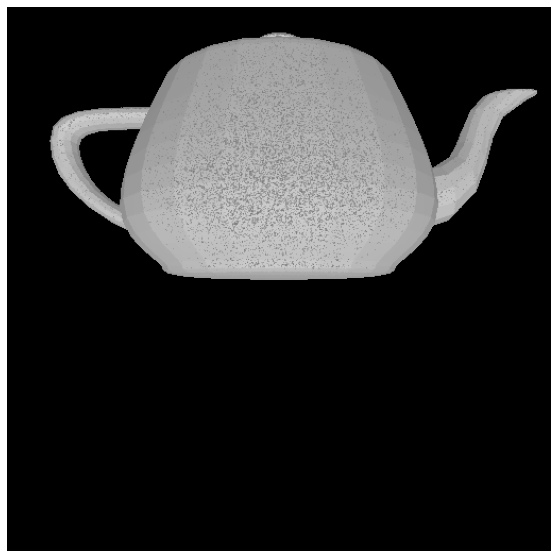

In [8]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)



# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)


n_points = 1000000
vertices, normals = sample_points_from_meshes(teapot_mesh, 
    n_points, return_normals=True)

vertices =  vertices[0].to(device)
normals =  normals[0].to(device)

rgb = torch.ones((n_points, 4), device=device) - 0.3

point_cloud = Pointclouds(points=[vertices], 
                          normals=[normals],
                          features=[rgb],
                         )


# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)

# Select the viewpoint using spherical angles
distance = 2 # Distance from camera to the objectlights = PointLights(device=device, location=[[0.0, -1.0, 3.0]])
elevation = 0. # angle of elevation in degrees
azimuth = 0.0 # No rotation so the camera is positioned on the +Z axis

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
#R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
lights = PointLights(device=device, location=[[0.0, -1.0, 3.0]])

raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 4
)
rasterizer = PointsRasterizer(cameras=cameras, 
    raster_settings=raster_settings)

compositor = ShadingCompositor(device=device, 
        cameras=cameras,
        lights=lights)


renderer =  ShadingPointsRenderer(
    rasterizer=rasterizer,
    compositor=compositor,
)       

images =  renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [10]:
stl_dir = "./data/stls/"

file_name = "./data/flame_sample.stl"
print(file_name)
latitudes_num = 2000
paths = gather_all_paths(file_name, latitudes_num)
print(len(paths))

samples_num = 500
samples = sample_all_paths(paths, samples_num)
print(samples[0].shape, samples[1].shape)

./data/flame_sample.stl
2000
(1000, 1000, 3) (1000, 1000, 3)


In [11]:
head_vertices =  torch.tensor(samples[0]).float().reshape(-1, 3).to(device)#.flip(-1)
head_normals =  torch.tensor(samples[1]).float().reshape(-1, 3).to(device)#.flip(-1)
head_vertices.shape, head_normals.shape

(torch.Size([1000000, 3]), torch.Size([1000000, 3]))

torch.Size([1000000, 4])


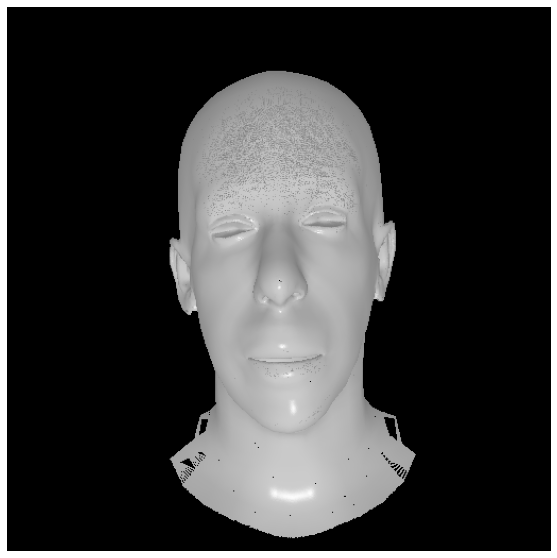

In [12]:
head_rgb = torch.ones((head_vertices.shape[0], 4), device=device) - 0.3
print(head_rgb.shape)
head_point_cloud = Pointclouds(points=[head_vertices], 
                          normals=[head_normals],
                          features=[head_rgb],)
head_point_cloud
images =  renderer(head_point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [6]:
head_vertices.flip(-1)

tensor([[-0.4745, -0.0416, -0.1518],
        [-0.4903, -0.0409, -0.0991],
        [-0.4745, -0.0404, -0.1542],
        ...,
        [-0.5597,  0.0586, -0.0096],
        [-0.5340,  0.0058,  0.0382],
        [-0.5618,  0.0589,  0.0386]], device='cuda:0')